In [1]:
import numpy as np
import cmath
import scqubits as scq
import matplotlib.pyplot as plt

import chencrafts.toolbox as tb
import chencrafts.cqed as cqed

import qutip as qt

from fluxonium_tunable_coupler import FluxoniumTunableCouplerGrounded, ConstructFullPulse

scq.settings.PROGRESSBAR_DISABLED = True
import chencrafts
chencrafts.settings.PROGRESSBAR_DISABLED = True
def FTC_system(
    E_Ja, E_Jb, 
    E_Ca, E_Cb, 
    E_La, E_Lb,
    E_C, ECm, E_L1, E_L2, E_J,
    flux_a, flux_b, flux_c, 
    **kwargs
):
    FTC_grounded = FluxoniumTunableCouplerGrounded(
        EJa=E_Ja, EJb=E_Jb, EC_twoqubit=np.inf,
        ECq1=E_Ca, ECq2=E_Cb, ELa=E_La, ELb=E_Lb,
        flux_a=flux_a, flux_b=flux_b, flux_c=flux_c,
        fluxonium_cutoff=130, fluxonium_truncated_dim=5,
        ECc=E_C, ECm=ECm, EL1=E_L1, EL2=E_L2, EJC=E_J,
        fluxonium_minus_truncated_dim=7, h_o_truncated_dim=4
    )

    return FTC_grounded


In [119]:
para_exp = {
    'E_Ja': 4.9,
    'E_Jb': 5.5,
    'E_Ca': 1.5,
    'E_Cb': 1.5,
    'E_J': 3,
    'E_C': 2,
    'ECm': 50,
    'E_L2': 10,
    'E_L1': 10,
    'E_La': 0.4,
    'E_Lb': 0.4,
}


In [120]:
from functions import*
FTC_grounded = FTC_system(
    **para_exp,
    flux_a = 0.5,
    flux_b = 0.5,
    flux_c = 0.2,
)


In [121]:
# hs = FTC_grounded.generate_coupled_system_sweetspot()
# H0 = (hs.bare_hamiltonian()/2/np.pi).full()
# V = hs.interaction_hamiltonian().full()
# H0, V = shuffle_matrices(H0, V)
# swt_result = swt_subspace(H0, V, [0, 1, 2, 3])

# # Sum the relevant submatrices
# sum_matrix = sum(swt_result[1][i][0:6, 0:6] for i in range(4))

# # Calculate specific matrix elements
# element_sum = (np.abs(sum_matrix[0, 1]) + np.abs(sum_matrix[0, 2]) + 
#                 np.abs(sum_matrix[1, 3]) + np.abs(sum_matrix[2, 3]))
    

In [122]:
fluxm = FTC_grounded.fluxonium_minus()
osc = FTC_grounded.h_o_plus()
fluxa = FTC_grounded.fluxonium_a()
fluxb = FTC_grounded.fluxonium_b()

In [123]:
fluxa.eigenvals()-fluxa.eigenvals()[0]

array([ 0.      ,  0.312512,  5.301372,  7.447311, 10.909619, 13.118668])

In [124]:
fluxb.eigenvals()-fluxb.eigenvals()[0]

array([ 0.      ,  0.246639,  5.715375,  7.699805, 11.365268, 13.511369])

In [125]:
fluxm.phi_operator(energy_esys=True)

array([[-3.131836e-01, -8.860266e-01,  5.613460e-02, -2.347788e-03, -3.555739e-03, -2.870089e-04, -2.757053e-04],
       [-8.860266e-01, -7.868359e-02,  1.285651e+00,  8.454045e-02, -2.473676e-03, -6.967390e-03,  4.203121e-04],
       [ 5.613460e-02,  1.285651e+00,  1.092751e-01, -1.598667e+00, -8.884489e-02,  2.528882e-03, -1.011893e-02],
       [-2.347788e-03,  8.454045e-02, -1.598667e+00,  2.090107e-01, -1.859392e+00, -7.501882e-02, -3.204397e-03],
       [-3.555739e-03, -2.473676e-03, -8.884489e-02, -1.859392e+00,  2.304836e-01, -2.085775e+00,  5.250634e-02],
       [-2.870089e-04, -6.967390e-03,  2.528882e-03, -7.501882e-02, -2.085775e+00,  2.026135e-01,  2.288819e+00],
       [-2.757053e-04,  4.203121e-04, -1.011893e-02, -3.204397e-03,  5.250634e-02,  2.288819e+00,  1.480927e-01]])

In [126]:
from joblib import Parallel, delayed

# Define the function to compute eigenvalues for a given flux_c
def compute_eigenvals(flux_c):
    FTC_grounded = FTC_system(
        **para_exp,
        flux_a=0.5 ,
        flux_b=0.5 ,
        flux_c=flux_c,
    )
    fluxsh = FTC_grounded.find_flux_shift_exactyw()
    fluxa = fluxsh[0]
    fluxb = fluxsh[1]
    FTC_grounded = FTC_system(
        **para_exp,
        flux_a=fluxa, 
        flux_b=fluxb,
        flux_c=flux_c,
    )
    eigenvals = FTC_grounded.eigenvals()
    eigenvals = eigenvals[:4] - eigenvals[0]  # Ensure compatible shapes
    return eigenvals

# compute_eigenvals(0.3)


Optimization terminated successfully.
         Current function value: 0.546359
         Iterations: 18
         Function evaluations: 37
Optimization terminated successfully.
         Current function value: 0.543628
         Iterations: 21
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: 0.540987
         Iterations: 18
         Function evaluations: 37
Optimization terminated successfully.
         Current function value: 0.546178
         Iterations: 19
         Function evaluations: 38
Optimization terminated successfully.
         Current function value: 0.546257
         Iterations: 19
         Function evaluations: 38
Optimization terminated successfully.
         Current function value: 0.540961
         Iterations: 19
         Function evaluations: 38
Optimization terminated successfully.
         Current function value: 0.546348
         Iterations: 21
         Function evaluations: 40
Optimization terminated successful

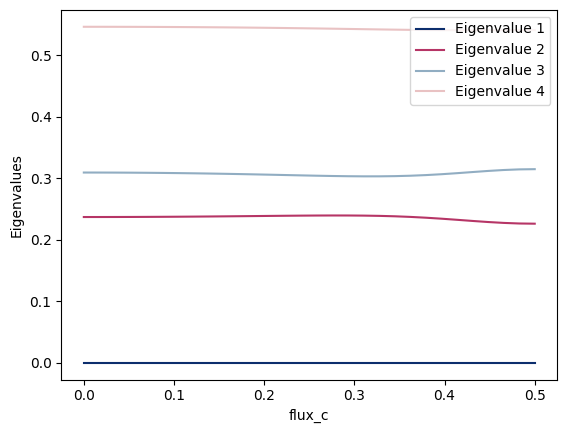

In [127]:

# Generate flux_c values
flux_c_values = np.linspace(0, 0.5, 30)

# Use joblib to parallelize the computation
eigenvals_list = Parallel(n_jobs=-1)(delayed(compute_eigenvals)(flux_c) for flux_c in flux_c_values)

# Convert the list of eigenvalues to a numpy array for easier plotting
eigenvals_array = np.array(eigenvals_list)

# Plot the first four elements of eigenvals
for i in range(4):
    plt.plot(flux_c_values, eigenvals_array[:, i], label=f'Eigenvalue {i+1}')

plt.xlabel('flux_c')
plt.ylabel('Eigenvalues')
plt.legend()
plt.show()

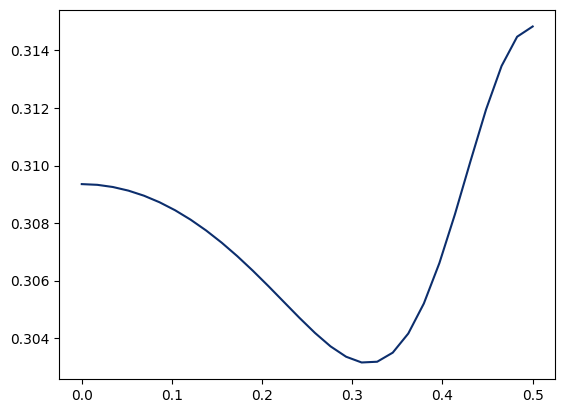

In [130]:
plt.plot(flux_c_values, eigenvals_array[:, 2], label=f'Eigenvalue {i+1}')
plt.show()

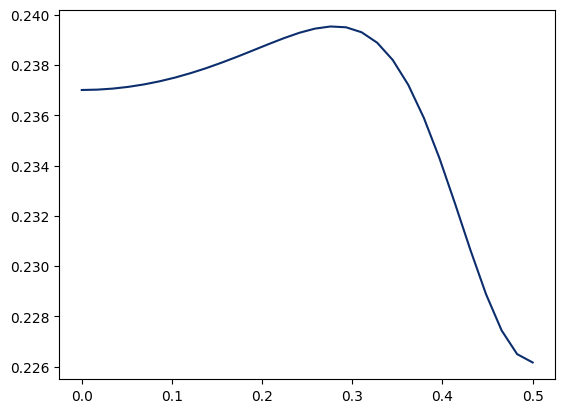

In [131]:
plt.plot(flux_c_values, eigenvals_array[:, 1], label=f'Eigenvalue {i+1}')
plt.show()

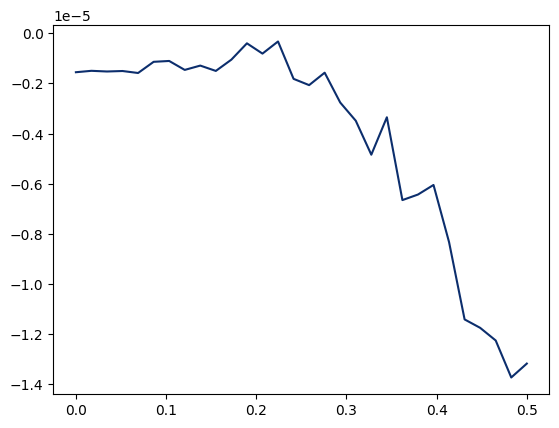

In [132]:
plt.plot(flux_c_values,eigenvals_array[:, 3]-eigenvals_array[:, 2]-eigenvals_array[:, 1])
plt.show()